## CLASSIFICATION: UNCLASSIFIED

## Data Preparation and Supervised Learning (Classification)
### Logistic Regression, Decision Trees and Random Forests

Supervised learning comes in two flavours, depending on the prediction task, namely:

* classification: the prediction task is to choose from a finite set of outcomes (discrete);
* regression: the prediction task is continuous, possibly restricted to some range;

In this notebook, we consider the following classification problem: classify the passengers of the Titanic as ''surviving'' or ''non-surviving'', using a handful of features. We will first look at data preparation, namely:

* 1-hot encoding for categorical features
* simple imputation for missing features, and
* dividing the data into training, (validation) and test sets.

We will then apply a few simple classifiers, namely:

* logistic regression
* decision trees
* random forests

and illustrate a few diagnostic tools:

* feature (or variable) importance measures
* data visualisation


## Loading csv data

We load the data into a pandas table (like a data frame in R); 
typically, each row is an instance, and each column is a feature.
In this case, the value we wish to model ('survived') is included as a column,
and we extract it in a separate vector.
We load the data from a csv (comma separated values) file.

In [1]:
## Titanic survival data
from IPython.core.display import Image
import pandas as pd
import numpy as np

import get_data
get_data.get_file("titanic3.csv", "../data/")

titanic = pd.read_csv('../data/titanic3.csv')
labels = titanic.survived.values
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Here is a description of the columns: 
```
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
survival        Survival
                (0 = No; 1 = Yes)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
boat            Lifeboat
body            Body Identification Number
home.dest       Home/Destination
```


## Feature selection and preparation

Some columns (ex: name) are not relevant for our task. We extract a subset of the columns
that have the potential of being useful predictors. There are several types of features:

* Numerical features, such as 'age', 'sibsp' and 'fare'
* Categorical features, for example 'pclass', 'sex' and 'embarked'

There are special types of categorical features, namely:

* Binary features (such as 'sex') which take on 2 possible values; we commonly encode such features as 0 or 1;
* Ordinal features (such as 'pclass'), where the categories can be ordered; we can encode such features numerically (for example, with successive integers), but it may not be clear how to choose the values to reflect the true scale. We can also use 1-hot encoding as with non-ordinal features (see below).

### 1-hot encoding

This is a commonly used method with categorical features. For each possible category, we create a new binary feature, which takes on value 1 only for instances with this category, and 0 otherwise. For category 'sex', two new features are created:


In [2]:
## example of 1-hot encoding
pd.get_dummies(titanic[['sex']]).head()

,sex_female,sex_male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


### Prepare data: select feature and apply 1-hot encoding

Below, we select a subset of the columns, apply 1-hot encoding to the categorical features, and build an array with those new columns. The resulting format is known as a ''numpy array'', here of dimensions 1309 x 12.

In [3]:
## pick a subset of columns
features = titanic[['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked']]

## 1-hot encoding (a.k.a. dummy variables) for categorical features
features_categ = pd.get_dummies(features, columns=['pclass', 'sex', 'embarked'])
data = features_categ.values ## numpy array
data.shape

(1309, 12)

### Training, Validation and Test Subsets 

A supervised classification model is designed to label new data.
In order to test this ability to ''generalize'', we usually divide the training data, for which 
we have known labels, into 2 sets, namely:

* a training set, which is used to build the model, and
* a test set, used to measure its performance.

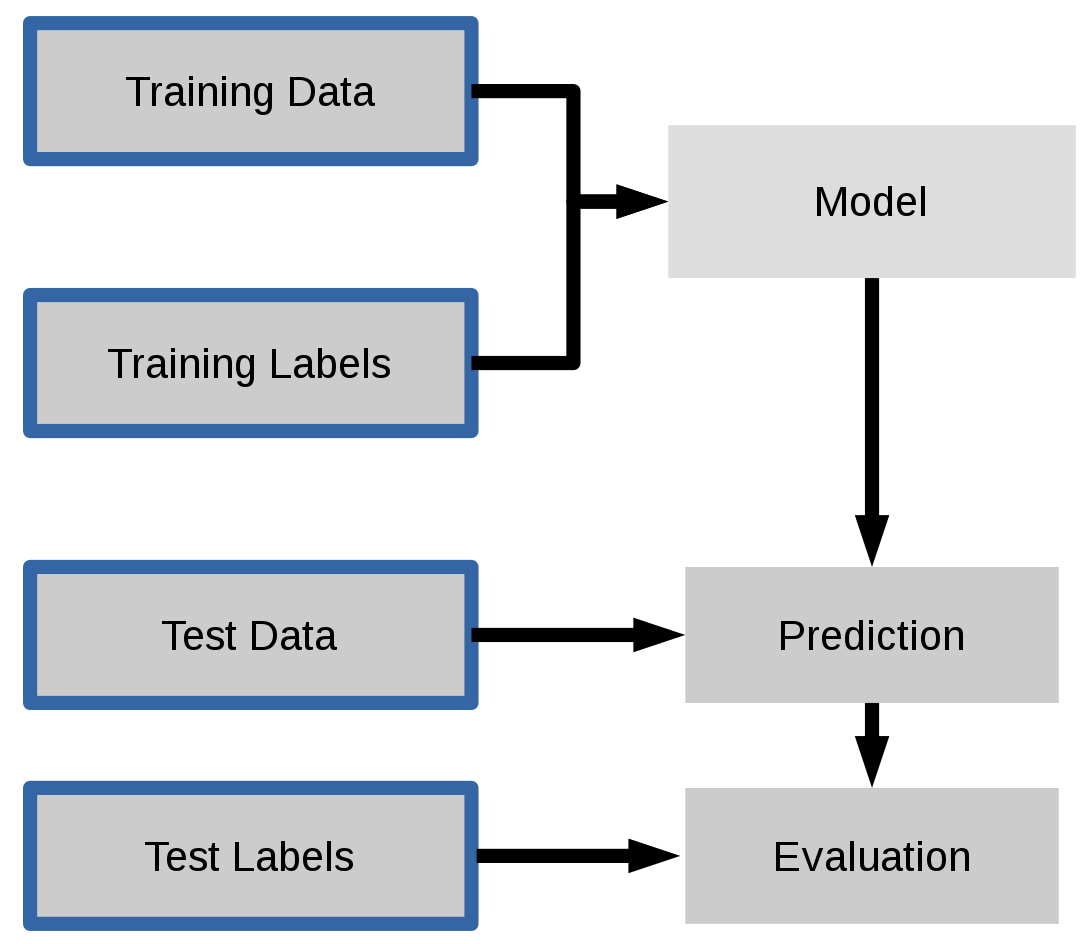

In [4]:
Image("./trainTest.png",width=350)

Measuring performance on the training set is a common error that leads to problems such as 'overfitting'.

Cross-validation refers to a procedure where the data in divided into $k$ subsets of roughly equal size, and each subset in turn is used as the test set, with the rest of the data used for training.

For some models, it is necessary to set some parameters empirically, in which case the data is usually
divided in three sets:

* a training set, which is used to build the model, and
* a validation set, which is used to measure the performance w.r.t. various choices of parameters, and
* a test set, used to measure the performance of the final model.


In [5]:
## train/test split
## we use 2/3 for training, 1/3 for testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.33)


### Missing Values

Several supervised learning algorithms can not handle missing values in the features, so we need to apply ''imputation'' to fill in those values. Some simple imputation methods are to replace the missing value(s) in a column with either:

* the column mean,
* the column median,
* the column mode (most frequent value).

We use the column mean below. 
Note that the imputation model is built on the ''training'' data.


In [6]:
## impute missings with mean column value
from sklearn.preprocessing import Imputer

## impute missing values with column mean (from training set)
## other common strategies are: median value, most common value.
imp = Imputer(strategy='mean')
imp.fit(X_train)
X_train_clean = imp.transform(X_train)

## impute missings for test set
X_test_clean = imp.transform(X_test)

## number of missing values before and after
print('missing before imputation:',np.isnan(X_train).sum(),'after:',np.isnan(X_train_clean).sum())

missing before imputation: 178 after: 0


# Logistic Regression

In its most commonly used version, 
logistic regression is a regression model over a ''binary'' response variable:
$Y \in \{0, 1\}$ and a set of explanatory variables (features) $X=(X_1,...,X_k)$
which can be numerical or categorical. Categorical features are typically 1-hot encoded
first. The model learns the conditional probability: 

$$
\Pi_i = Pr\left(Y_i=1 ~|~ X_i = (X_{i,1},...,X_{i,k})\right).
$$

The model is of the following form:

$$
\log\left(\frac{\Pi_i}{1-\Pi_i}\right) = \beta_0 + \beta_1 X_{i,1} + ... + \beta_k X_{i,k}
$$

For classification, we use the prediction $Y_i = 1$ if $\Pi_i \ge \Theta$, or $Y_1 = 0 $ otherwise,
with $\Theta = 0.5$ the default threshold.

The coefficients $\beta_i$ are interpretable, their sign and magnitude being an indication of the effect of the predictor on the response variable.

With our training data already prepared (1-hot encoding for categoricals, imputation for missing values), we train a logistic regression model for the Titanic data.


In [7]:
## Logistic regression
## fit the model with training data
from sklearn.linear_model import LogisticRegression
logReg = LogisticRegression()
logReg.fit(X_train_clean, Y_train);


### Prediction (on the test data)

Next, we apply the logistic regression model to the test data in two different ways:

* predict the probabilities (the $\Pi_i$), and
* predict the response (the $Y_i$).

We compare the predicted responses with the true labels and compute the accuracy score.

In [8]:
## 1. predict the probabilities [P(not survived), P(survived)]
##    print first 5
proba = logReg.predict_proba(X_test_clean)
print(proba[:5],'\n')

## 2. predict the actual (binary) class (1=survived, 0=not)
##    print first 5
pred = logReg.predict(X_test_clean)
print(pred[:5],'\n')

## 3. accuracy score: proportion correctly labelled
print('accuracy =',logReg.score(X_test_clean, Y_test))


[[ 0.86897535  0.13102465]
 [ 0.73817908  0.26182092]
 [ 0.97567715  0.02432285]
 [ 0.24848639  0.75151361]
 [ 0.72554133  0.27445867]] 

[0 0 0 1 0] 

accuracy = 0.770833333333


### Coefficients

Next, we look at the coefficients corresponding to the features, the $\beta_j$. There are some clear interpretations from those, such as:

* the strong correlation between the passenger class (1st, 2nd, 3rd) and survival;
* the strong correlation between gender and survival, and
* some (surprising?) correlation between port of embarkation and survival.

            logReg coefficient
age                  -0.035276
sibsp                -0.318053
parch                -0.041678
fare                  0.004948
pclass_1              0.997365
pclass_2              0.284851
pclass_3             -0.657448
sex_female            1.596406
sex_male             -0.971639
embarked_C            0.318652
embarked_Q            0.137521
embarked_S           -0.115421


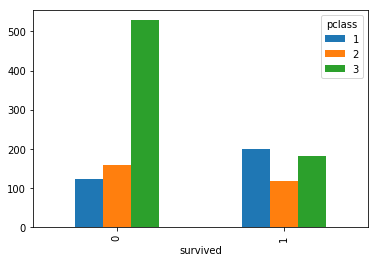

In [9]:
## show the coefficients in a data frame
F = pd.DataFrame(logReg.coef_.ravel() , features_categ.columns.ravel(), columns=['logReg coefficient'])
print(F)

## barplot 'pclass' categorized via 'survived' over original data frame
import matplotlib.pyplot as plt
%matplotlib inline
pd.crosstab(titanic.survived, titanic.pclass).plot(kind='bar');


## Other evaluation metrics

We already saw the ''accuracy'' as a measure of the quality of the model, the proportion of the test labels are predicted correctly.

There are other commonly used measures of quality, and we illustrate a few. First, we look at the confusion table 
$
\left(
\begin{array}{cc}
TN & FP \\
FN & TP \\
\end{array}
\right)
$
where:

* TN: number of True Negatives, i.e. $Y_i=0$ predicted correctly
* FP: number of False Positives, i.e. $Y_i=0$ predicted incorrectly
* FN: number of False Negatives, i.e. $Y_i=1$ predicted incorrectly
* TP: number of True Positives, i.e. $Y_i=1$ predicted correctly

Some derived measures:

* Precision (negatives): $\frac{TN}{TN+FN}$
* Precision (positives): $\frac{TP}{TP+FP}$ 
* Recall (negatives): $\frac{TN}{TN+FP}$
* Recall (positives): $\frac{TP}{TP+FN}$

and the F1 score, computed as
$ F1 = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}. $

### ROC and AUC

When the predictions are given in terms of probabilities or some other continuous values, it is common to look at the results with a ROC curve (receiver operating characteristic), and to compute the area under the curve (AUC).

Given a decision threshold $\theta$, we use the
prediction $Y_i = 1$ if $\Pi_i \ge \theta$, or $Y_1 = 0 $ otherwise. We
compute the True Positive Rate $TPR = \frac{TP}{TP+FN}$ and the False Positive Rate $FPR = \frac{FP}{FP+TN}$.
The ROC curve is built by considering different values for the decision threshold $\theta$, and plotting the values TPR vs FPR. 

The AUC is the area under the ROC curve. If all positive cases have higher probabilities than all negative cases, we obtain $AUC = 1$.


Confusion matrix:
 [[235  51]
 [ 48  98]] 

             precision    recall  f1-score   support

          0       0.83      0.82      0.83       286
          1       0.66      0.67      0.66       146

avg / total       0.77      0.77      0.77       432



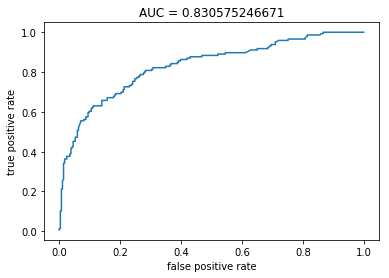

In [10]:
from sklearn import metrics

## confusion matrix
print('Confusion matrix:\n',metrics.confusion_matrix(Y_test, pred),'\n')

## precision, recall, F1
print(metrics.classification_report(Y_test, pred))

## ROC and AUC
auc = metrics.roc_auc_score(Y_test, proba[:,1])
fpr, tpr, thresh = metrics.roc_curve(Y_test, proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('AUC = '+str(auc))
plt.show()


# Decision Trees

Decision trees are simple, very interpretable models for classification or regression.
With binary trees, each node corresponds to a split with respect to one of the features
available. Classification (or regression) is done by looking at all training cases that 
end up at each leaf node.

Several parameters can be set with such models, two of which are:

* the maximum depth: shallow trees are very interpretable, but may lack accuracy; on the other hand, deep trees can overfit to the training data; a validation set can be used to help set this value;
* the splitting criterion; by default the Gini index is used, which measures the label "impurity" are each node; the other commonly used criterion is entropy.

Below we build a shallow decision tree to allow for visualization. We also measure accuracy on the test set, and display variable importance.


In [11]:
## Tree classification - shallow for easy viz
from sklearn.tree import DecisionTreeClassifier
myTree = DecisionTreeClassifier(max_depth=3)
myTree.fit(X_train_clean, Y_train)

## accuracy on the test set
print('accuracy = ',myTree.score(X_test_clean, Y_test),'\n')

## feature importance
F = pd.DataFrame(myTree.feature_importances_, features_categ.columns.ravel(), columns=['tree'])
print('variable importance:\n',F)


accuracy =  0.80787037037 

variable importance:
                 tree
age         0.053224
sibsp       0.039201
parch       0.000000
fare        0.048779
pclass_1    0.031077
pclass_2    0.000000
pclass_3    0.161237
sex_female  0.000000
sex_male    0.666482
embarked_C  0.000000
embarked_Q  0.000000
embarked_S  0.000000


## Variable Importance and Tree Visualization

Variable importance measures are useful, but may be misleading since it is often the interaction between the various features that matters. With a simple decision tree, visualizing the resulting model may bring more insight. As we see below, gender is the most important predictor. However, for male passengers (left branch), the next discriminating factor is age, while for female passengers, it is the the passenger class.  

In [14]:
## Tree viz with graphviz and pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO
import pydotplus
dotData = StringIO()
tree.export_graphviz(myTree, out_file=dotData, feature_names=features_categ.columns.ravel())
graph = pydotplus.graph_from_dot_data(dotData.getvalue())
graph.write_png("./dt.png");


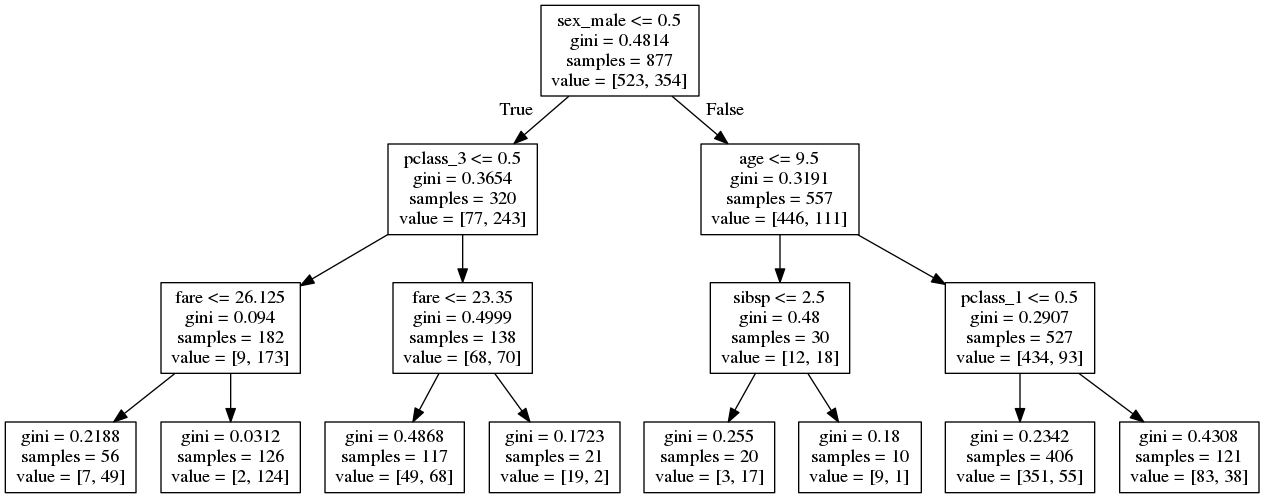

In [16]:
Image("./dt.png", width=800)

# Random Forest Classification

As the name suggests, a random forest is a collection of decision trees; randomization allows to explore the feature and data spaces differently for each tree, namely:

* various sub-samples of the training data are used, and
* various sub-samples of the features are considered for splitting.

There are several parameters that can be set, but in general, using the default values for most of those is fine, experimenting mainly with the number of trees (the ''n_estimators'') parameter, which can be set using a validation data set. In general, using too many trees does not affect the quality of the model, but it means bigger and slower models.

Random Forests are often recommanded as a ''black box'' choice for classification, as it almost always performs amongst the best models in empirical studies. It also has a very elegant procedure to estimate variable importance. Finally, given that the final classification is obtain from all the trees, we get a score (proportion of trees that voted for a given class) which we can treat as a pseudo-probability.


In [17]:
## Random Forest - here with 200 trees
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_clean, Y_train)

## accuracy score: proportion correctly labelled
print('accuracy =',rfc.score(X_test_clean, Y_test))


accuracy = 0.777777777778


### Variable Importance - Warnings

A word of warning regarding categorical variable importance with the Python/Sklearn implementation of random forests: unlike R, this implementation does not handle categorical features naturally, and the only way to include categorical features is via 1-hot encoding. Therefore, for variable importance, the importance for each possible value of a categorical variable is measured separately. This is not necessarily bad, but has to be taken into account.

For example, in the plot below, the importance of the gender is divided amongst the two possible outcomes (''sex_female'' and ''sex_male''). For binary features, we can remove one of the two without loss of information, but this is not so with multiple categories.

Another general issue with variable importance in random forests is the bias toward real-valued features vs categorical ones, in particular binary. This is very simple to see: once a split is made on a binary feature, there can be no further split with this feature on the subtrees below the split. However, with real-values features, they can be used for splitting multiple times in the same tree, thus boosting their importance score.


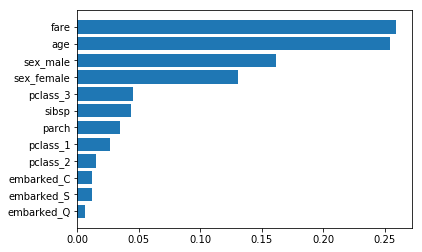

In [18]:
# Variable importance measures: sort and barplot
imp = np.argsort(rfc.feature_importances_)
plt.barh(range(12), rfc.feature_importances_[imp], tick_label=features_categ.columns[imp]);


### More feature importance and a Boxplot

Age comes out as very important, however, when we compare the age distribution of the passengers who survived with those who did not (below), we see very little difference. 
As we saw with the decision tree, this is likely due to the fact that this feature is important for classification only when used together with some other feature(s), such as gender.

Boxplots are very useful for quick EDA (exploratory data analysis) to visualize a distribution.
The red line is the median, the box contains most of the data, and any point outside the black 
horizontal bars are ''outliers''.


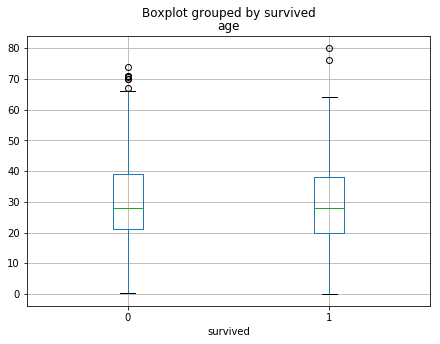

In [19]:
## Boxplot - 
titanic.boxplot(column='age',by='survived', showfliers=True, figsize=(7,5));


## ROC curve and AUC

Finally, since the prodictions from the forest can be viewed as probabilities, we can build a ROC curve and compute the area under it, as we did with logistic regression.


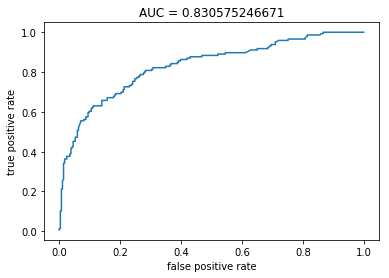

In [20]:
## ROC and AUC
auc = metrics.roc_auc_score(Y_test, proba[:,1])
fpr, tpr, thresh = metrics.roc_curve(Y_test, proba[:,1])
plt.plot(fpr,tpr)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('AUC = '+str(auc))
plt.show()